# Business Objective: Extracting sentiment from customer reviews on a product

### Data Set Details:
    - The dataset should be scraped/extracted from ecommerce websites like amazon etc.
    - Preferably amazon and focus only on extracting customer reviews , rest are not required
    - Need to deploy the end results (sentiment analysis) using Rshiny/ Streamlit /Flask etc.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded= files.upload()

Saving dataset.xlsx to dataset.xlsx


In [3]:
df= pd.read_excel('dataset.xlsx')
df.head()

,title,rating,body
0,Horrible product,1,Very disappointed with the overall performance...
1,Camera quality is not like 48 megapixel,3,Camera quality is low
2,Overall,4,"Got the mobile on the launch date,Battery must..."
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp..."


In [4]:
df.shape

(1427, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1427 non-null   object
 1   rating  1427 non-null   int64 
 2   body    1427 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.6+ KB


In [6]:
df.isnull().sum()

,0
title,0
rating,0
body,0


In [7]:
df.duplicated().sum()

np.int64(0)

# 1. Data Preprocessing
## 1.1 Add Sentiment Scores & labels

In [8]:
(df['rating'] == 3).sum()

np.int64(199)

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia= SentimentIntensityAnalyzer()

# Add Sentiment Scores using only VADER
df['sentiment_score']= df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])
# df['sentiment_label']= df['sentiment_score'].apply(lambda x: 'positive' if x > 0.0 else 'negative')

# Step 1: Manual label for ratings
def hybrid_label(row):
  if row['rating'] <= 2:
    return 'negative'
  elif row['rating'] >= 4:
    return 'positive'
  else:
    # Use VADER for rating == 3
    score= sia.polarity_scores(str(row['body']))['compound']
    return 'positive' if score >= 0 else 'negative'

df['sentiment_label']= df.apply(hybrid_label, axis= 1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [10]:
df.head()

,title,rating,body,sentiment_score,sentiment_label
0,Horrible product,1,Very disappointed with the overall performance...,-0.5256,negative
1,Camera quality is not like 48 megapixel,3,Camera quality is low,-0.2732,negative
2,Overall,4,"Got the mobile on the launch date,Battery must...",0.1027,positive
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....,-0.8923,negative
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp...",-0.8033,negative


## 1.2 Outlier detection and removal

In [11]:
#df['body_len']= df['body'].astype(str).apply(len)
df['body_len']= df['body'].apply(lambda x: len(str(x).split()))

In [12]:
df.head()

,title,rating,body,sentiment_score,sentiment_label,body_len
0,Horrible product,1,Very disappointed with the overall performance...,-0.5256,negative,8
1,Camera quality is not like 48 megapixel,3,Camera quality is low,-0.2732,negative,4
2,Overall,4,"Got the mobile on the launch date,Battery must...",0.1027,positive,66
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....,-0.8923,negative,67
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp...",-0.8033,negative,29


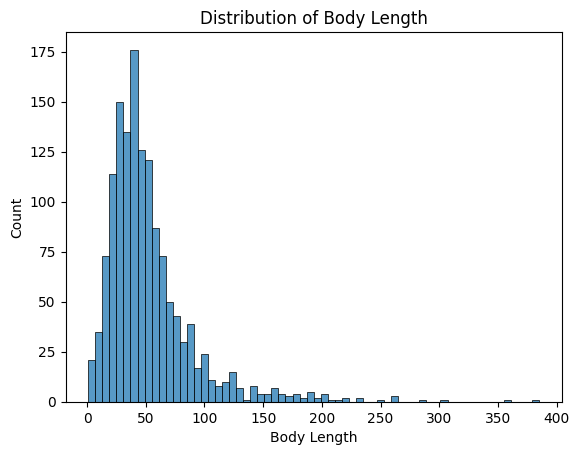

In [13]:
sns.histplot(data= df, x= 'body_len')
plt.xlabel('Body Length')
plt.ylabel('Count')
plt.title('Distribution of Body Length')
plt.show()

In [14]:
# Quantile-based Outlier treatment
q_low= df['body_len'].quantile(0.01)
q_high= df['body_len'].quantile(0.99)
df= df[(df['body_len'] >= q_low) & (df['body_len'] <= q_high)]

In [15]:
df.shape

(1402, 6)

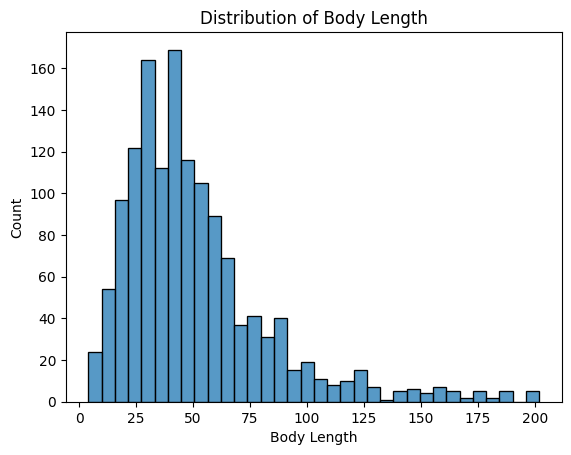

In [16]:
sns.histplot(data= df, x= 'body_len')
plt.xlabel('Body Length')
plt.ylabel('Count')
plt.title('Distribution of Body Length')
plt.show()

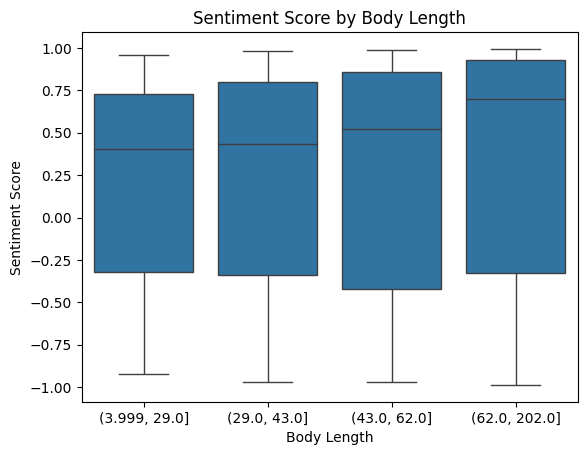

In [17]:
length_bin= pd.qcut(df['body_len'], q= 4)
sns.boxplot(x= length_bin, y= 'sentiment_score', data= df)
plt.xlabel('Body Length')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score by Body Length')
plt.show()

# 2. EDA

## 2.1 Count of Positive and Negative reviews

sentiment_label
positive    837
negative    565
Name: count, dtype: int64


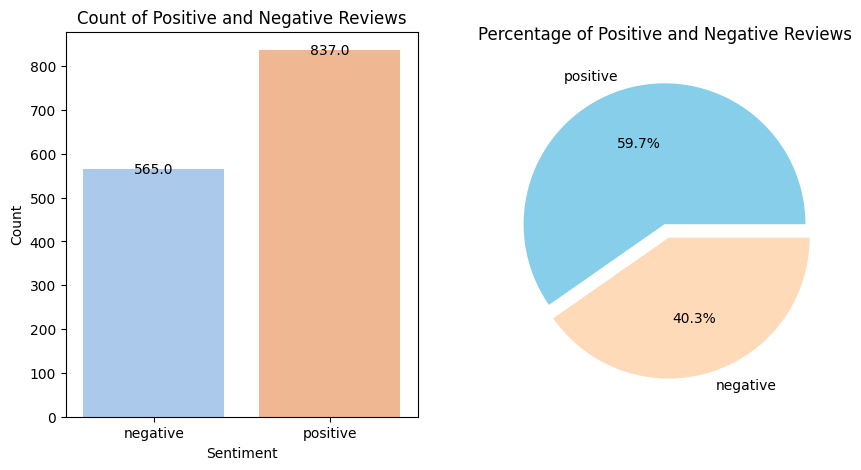

In [18]:
print(df['sentiment_label'].value_counts())

fig, ax= plt.subplots(1,2 , figsize= (10, 5))

# 1. COunt plot
a= sns.countplot(data= df, x='sentiment_label', ax= ax[0], palette= 'pastel')
a.set_title('Count of Positive and Negative Reviews')
a.set_xlabel('Sentiment')
a.set_ylabel('Count')

for p in a.patches:
  a.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha= 'center', va='center')

# Pie Chart
b= ax[1].pie(df['sentiment_label'].value_counts().values,
             explode= [0, 0.1],
             labels= df.sentiment_label.value_counts().index,
             autopct= "%1.1f%%",
             colors= ['SkyBlue', 'PeachPuff'])
ax[1].set_title('Percentage of Positive and Negative Reviews')
plt.show()

## 2.2 Distribution of the rating according to Positive and Negative reviews

rating
5    407
1    367
4    307
3    196
2    125
Name: count, dtype: int64


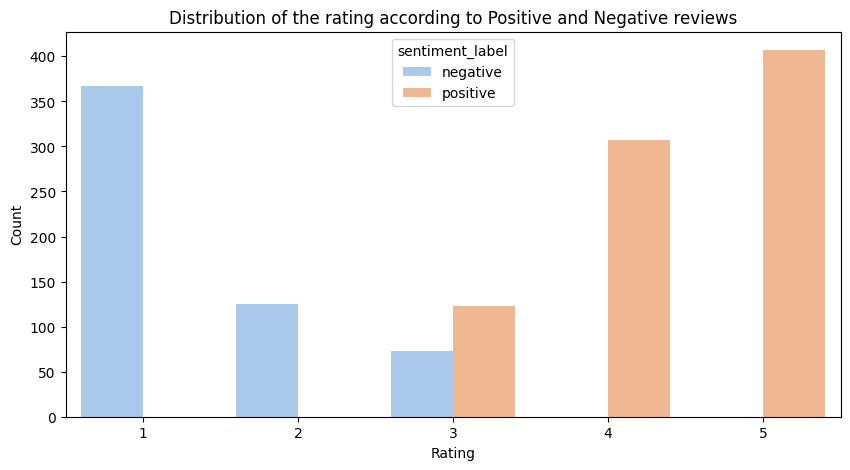

In [19]:
# 2.2 Stacked bar plots
print(df.rating.value_counts())
plt.figure(figsize= (10, 5))

ax= sns.countplot(data= df, x= 'rating', hue='sentiment_label', palette= 'pastel')
ax.set_title('Distribution of the rating according to Positive and Negative reviews')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
plt.show()

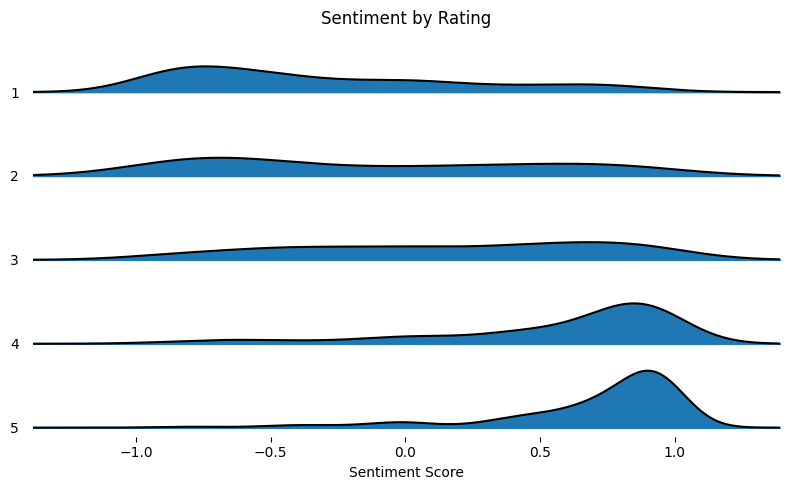

In [20]:
!pip install joypy
# 2.3 Joyplot (Ridgeline Plot)
import joypy

fig, ax= joypy.joyplot(df, by= 'rating', column= 'sentiment_score', figsize=(8, 5), kind= 'kde', title= 'Sentiment by Rating')
plt.xlabel('Sentiment Score')
plt.tight_layout()
plt.show()

In [21]:
# 2.4 Interactive Histogram + KDE
import plotly.express as px
fig= px.histogram(df, x= 'rating', nbins= 5, color='sentiment_label', marginal= 'rug', histnorm= 'percent')
fig.update_layout(title = 'Rating Distribution with Sentiment Classes')
fig.show()

In [22]:
# 2.5 Sentiment flow (Sankey)
import plotly.graph_objects as go

source= df['rating'].astype(str)
target= df['sentiment_label']
labels= sorted(list(set(source) | set(target)))
label_map= {k: i for i, k in enumerate(labels)}

sankey= go.Figure(data= [go.Sankey(
    node= dict(label=labels),
    link= dict(
        source= [label_map[s] for s in source],
        target= [label_map[t] for t in target],
        value= [1]*len(df)
    ))])
sankey.update_layout(title= 'Sentiment flow from rating', font_size= 10)
sankey.show()

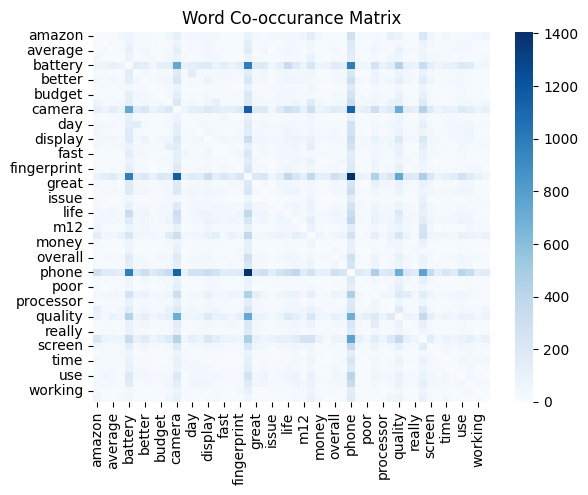

In [ ]:
# 2.6 Word Co-occurance Matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 50, stop_words= 'english')
X= vectorizer.fit_transform(df['body'])
Xc= (X.T * X) # Co-occurance matrix
Xc.setdiag(0)

cooc_df= pd.DataFrame(data= Xc.toarray(), index= vectorizer.get_feature_names_out(), columns= vectorizer.get_feature_names_out())
sns.heatmap(cooc_df, cmap= 'Blues')
plt.title('Word Co-occurance Matrix')
plt.show()

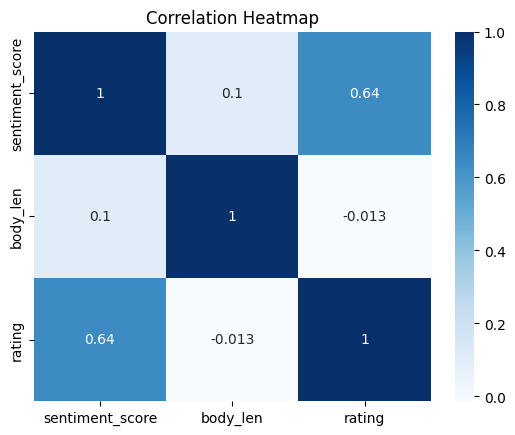

In [ ]:
# 2.7 Correlation
# Sentiment -Feature Correlation Heatmap
temp_df= df[['sentiment_score', 'body_len', 'rating']]
corr= temp_df.corr()
sns.heatmap(corr, annot= True, cmap= 'Blues')
plt.title('Correlation Heatmap')
plt.show()

# 3. Data Cleaning
#### 3.1. Merging the title and body column of the dataset
#### 3.2. Removal of HTML Contents,
#### 3.3. Remove Punctuation Marks & Special Characters,
#### 3.4. Removal of Stopwords,
#### 3.5. Lemmatization


In [ ]:
df.head()

,title,rating,body,sentiment_score,sentiment_label,body_len
0,Horrible product,1,Very disappointed with the overall performance...,-0.5256,negative,8
1,Camera quality is not like 48 megapixel,3,Camera quality is low,-0.2732,negative,4
2,Overall,4,"Got the mobile on the launch date,Battery must...",0.1027,positive,66
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....,-0.8923,negative,67
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp...",-0.8033,negative,29


In [ ]:
df['text'] = df['title'] + ' ' + df['body'] # This line combines the values from two columns ( 'title', and 'body') into a new column called 'text.'
df['sentiment_label'] = df['sentiment_label'].map({'positive': 1, 'negative': 0})
del df['title']
del df['body']
del df['body_len']
df.head()

,rating,sentiment_score,sentiment_label,text
0,1,-0.5256,0,Horrible product Very disappointed with the ov...
1,3,-0.2732,0,Camera quality is not like 48 megapixel Camera...
2,4,0.1027,1,"Overall Got the mobile on the launch date,Batt..."
3,1,-0.8923,0,A big no from me 1. It doesn't work with 5.0GH...
4,1,-0.8033,0,Put your money somewhere else Not worth buying...


In [ ]:
!pip install bs4

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

# Download stopwords and punkt data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Precompute stopwords set
stop_words= set(stopwords.words('english'))

# Removal of HTML Content
def remove_html(text):
  soup= BeautifulSoup(text, 'html.parser')
  return soup.get_text()

# Remove of Puntuation Marks
def remove_punctuation(text):
  return re.sub(r'[^\w\s]', '', text)

# Removal of special characters
def remove_characters(text):
  return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Lemmitization and removal of stopwrods
def preprocess_text(text):
  text= text.lower()
  words= nltk.word_tokenize(text)
  lemma= WordNetLemmatizer()
  final_words= [lemma.lemmatize(word) for word in words if word not in stop_words]
  return ' '.join(final_words)

# Total function
def cleaning(text):
  text= remove_html(text)
  text= remove_punctuation(text)
  text= remove_characters(text)
  text= preprocess_text(text)
  return text

# Apply function on text column
df['text']= df['text'].apply(cleaning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import re

words_to_remove= ['phone', 'samsung', 'mobile', 'good', 'product', 'amazon']

def remove_words(text, words):
  pattern= r'\b(' + '|'.join(words) + r')\b'
  return re.sub(pattern, '', text, flags= re.IGNORECASE).strip()

df['text']= df['text'].apply(lambda x: remove_words(x, words_to_remove))

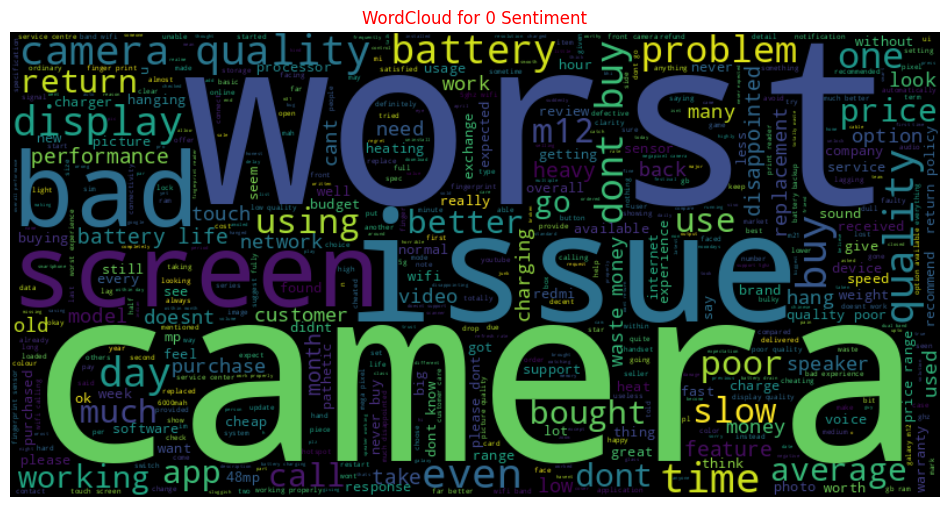

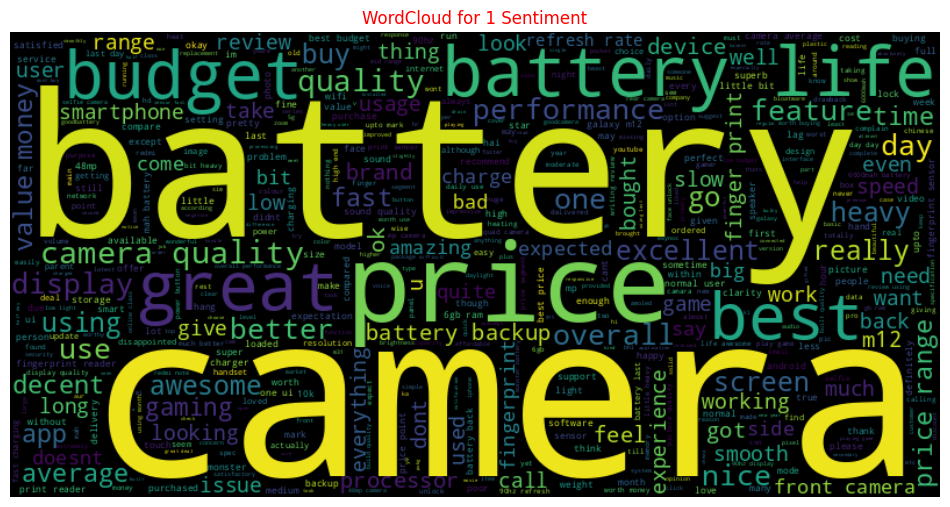

In [ ]:
# 2.8 WordCloud by Sentiment
from wordcloud import WordCloud
for sentiment in df['sentiment_label'].unique():
  text= ' '.join(df[df['sentiment_label'] == sentiment]['text'])
  wordcloud= WordCloud(max_words= 500, width= 800, height= 400, background_color='black').generate(text)
  plt.figure(figsize= (12,8))
  plt.axis('off')
  plt.imshow(wordcloud, interpolation= 'bilinear')
  plt.title(f'WordCloud for {sentiment} Sentiment', color='red')
  plt.show()

## 3.6. N-Gram Analysis

In [ ]:
all_text= ' '.join(df['text'].astype(str))

In [ ]:
def draw_n_grams(text, n, top= 15):
  tokens= all_text.split()
  n_grams= [' '.join(gram) for gram in nltk.ngrams(tokens, n)]
  n_gram_count= pd.Series(n_grams).value_counts().head(top)


  n_gram_df= n_gram_count.reset_index()
  n_gram_df.columns= ['word', 'count']

  plt.figure(figsize= (10, 5))
  sns.barplot(x='count', y='word', data= n_gram_df, palette= 'pastel')
  plt.title(f'Top {top}--> {n}-grams')
  plt.xlabel('Count')
  plt.ylabel('Word')
  plt.show()

### 3.6.1. Uni-gram analysis

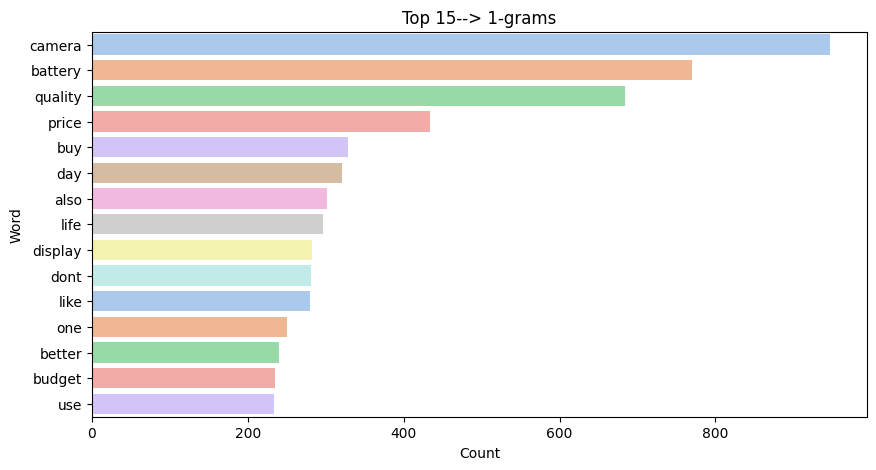

In [ ]:
draw_n_grams(all_text, 1, top=15)

### 3.6.2. Bi-gram analysis

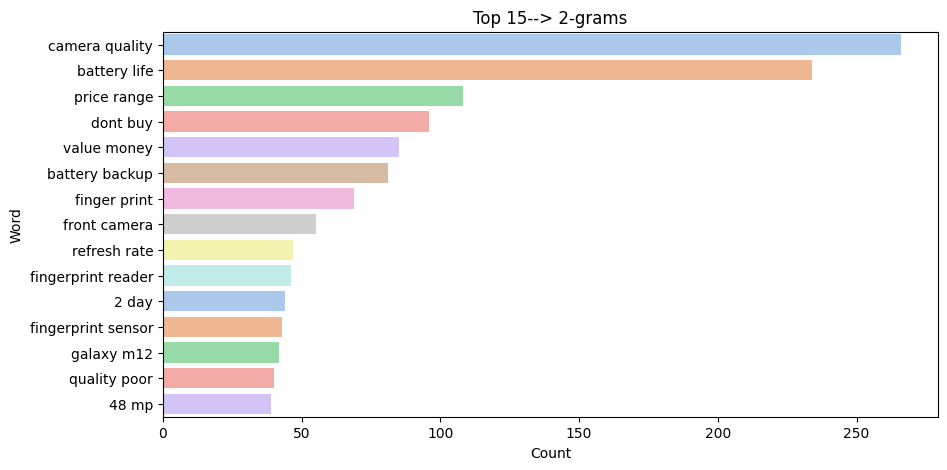

In [ ]:
draw_n_grams(all_text, 2, top=15)

### 3.6.3. Tri-gram analysis

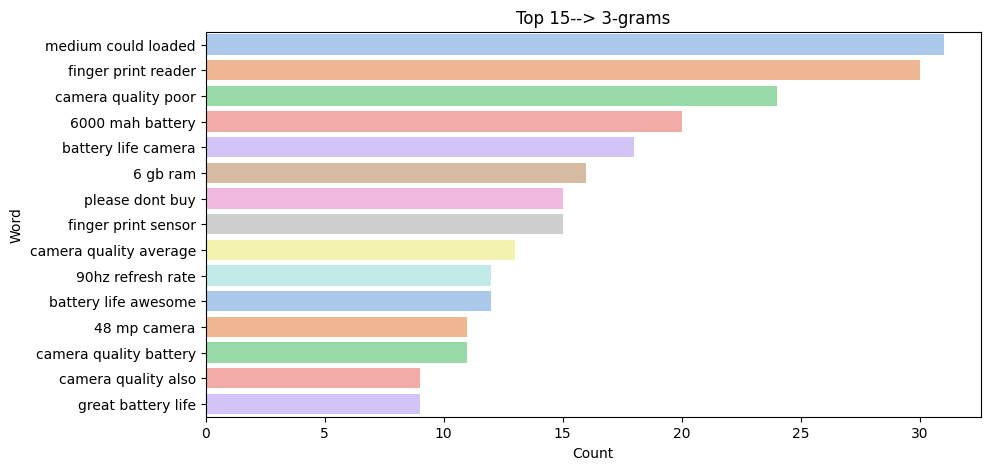

In [ ]:
draw_n_grams(all_text, 3, top=15)

## 4. Feature Engineering & Splitting

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# Splitting data into features (X), and target(y)
X_text= df['text']
y= df['sentiment_label']

X_train_text, X_test_text, y_train, y_test= train_test_split(X_text, y, test_size= 0.2, random_state= 42, stratify= y)

# Convert text into numerical format using TF-IDF
vectorizer= TfidfVectorizer(
    max_features=1000,
    min_df= 2, # removes rare words (less than 3 documents)
    max_df= 0.9, # removes very frequent words (in >90% of docs)
    stop_words= 'english', # removes English stop words
    ngram_range=(1,2)) # includes unigrams and bigrams

X_train= vectorizer.fit_transform(X_train_text)
X_test= vectorizer.transform(X_test_text)

# 5. Model Building

## 5.1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

param_dist_lr= {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

lr_model= LogisticRegression(solver= 'liblinear', max_iter= 1000)

random_search_lr= RandomizedSearchCV(lr_model, param_distributions= param_dist_lr, n_iter= 10, cv= 5, n_jobs= -1, verbose= 2, random_state= 42)
# Fit the model
random_search_lr.fit(X_train, y_train)

# Get the best model
best_lr_model= random_search_lr.best_estimator_
best_params= random_search_lr.best_params_
print("Best Parameters;", random_search_lr.best_params_)

# Predict on the test set
y_pred_lr= best_lr_model.predict(X_test)

# Evalutte
accuracy_lr= accuracy_score(y_test, y_pred_lr)
print("Accuracy;", accuracy_lr)

print('\n Classification Report:')
print(classification_report(y_test, y_pred_lr))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters; {'penalty': 'l2', 'C': 10}
Accuracy; 0.8790035587188612

 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       113
           1       0.87      0.94      0.90       168

    accuracy                           0.88       281
   macro avg       0.88      0.86      0.87       281
weighted avg       0.88      0.88      0.88       281


 Confusion Matrix:
[[ 89  24]
 [ 10 158]]


## 5.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid
param_dist_rf= {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2,3,5,7],
    'min_samples_leaf': [1,2,3],
    'max_features': ['sqrt', 'log2']
}

rf_model= RandomForestClassifier(random_state= 42)

# Set up RandomizedSearchCV
random_search_rf= RandomizedSearchCV(rf_model, param_distributions= param_dist_rf, n_iter= 30, cv= 5, n_jobs= -1, verbose= 2, random_state= 42)

# Fit the model
random_search_rf.fit(X_train, y_train)

# Get the best model
best_rf_model= random_search_rf.best_estimator_
best_params= random_search_rf.best_params_
print('Best Parameters:', best_params)

# Predict on the test set
y_pred_rf= best_rf_model.predict(X_test)

# Evaluate the model
accuracy_rf= accuracy_score(y_test, y_pred_rf)
print('Accuracy:', accuracy_rf)

print('\n Classification Report:')
print(classification_report(y_test, y_pred_rf))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuracy: 0.8291814946619217

 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       113
           1       0.81      0.93      0.87       168

    accuracy                           0.83       281
   macro avg       0.84      0.80      0.81       281
weighted avg       0.84      0.83      0.82       281


 Confusion Matrix:
[[ 76  37]
 [ 11 157]]


## 5.3. SVM

In [ ]:
from sklearn.svm import SVC

svm_model= SVC(probability= True)

# Define hyperparameter distributions
param_dist_svm= {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

# Initialize RandomizedSEARCH
random_search_svm= RandomizedSearchCV(estimator= svm_model, param_distributions= param_dist_svm, n_iter= 30, cv= 5, n_jobs= -1, verbose= 2, random_state= 42)

# Fit the modle
random_search_svm.fit(X_train, y_train)

# Get the best model
best_svm_model= random_search_svm.best_estimator_
best_param= random_search_svm.best_params_
print('Best Parameters:', best_param)

# Predict on the test set
y_pred_svm= best_svm_model.predict(X_test)

# Evaluate the model
accuracy_svm= accuracy_score(y_test, y_pred_svm)
print('Accuracy:', accuracy_svm)

print('\n Classification Report:')
print(classification_report(y_test, y_pred_svm))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'kernel': 'sigmoid', 'gamma': 'scale', 'C': np.float64(1.0)}
Accuracy: 0.8327402135231317

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       113
           1       0.83      0.90      0.87       168

    accuracy                           0.83       281
   macro avg       0.83      0.82      0.82       281
weighted avg       0.83      0.83      0.83       281


 Confusion Matrix:
[[ 82  31]
 [ 16 152]]


## 5.4. LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm_model= LGBMClassifier(random_state= 42, n_jobs= -1)

# Define hyperparameter distributions
param_dist_lgbm= {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [-1, 10, 20, 30],
    'num_leaves': [15, 31, 65, 127],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up Randomsearchcv
random_search_lgbm= RandomizedSearchCV(estimator= lgbm_model, param_distributions= param_dist_lgbm, n_iter= 30, cv= 5, scoring= 'accuracy', n_jobs= -1, verbose= 2, random_state= 42)

# Fit the model
random_search_lgbm.fit(X_train, y_train)

# Get the best model
best_lgbm_model= random_search_lgbm.best_estimator_
best_param= random_search_lgbm.best_params_
print('Best Parameters:', best_param)

# Predict on test
y_pred_lgbm= best_lgbm_model.predict(X_test)

# Evaluate the model
accuracy_lgbm= accuracy_score(y_test, y_pred_lgbm)
print('Accuracy:', accuracy_lgbm)

print('\n Classification Report:')
print(classification_report(y_test, y_pred_lgbm))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 669, number of negative: 452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4340
[LightGBM] [Info] Number of data points in the train set: 1121, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596789 -> initscore=0.392102
[LightGBM] [Info] Start training from score 0.392102
Best Parameters: {'subsample': 1.0, 'num_leaves': 15, 'n_estimators': 100, 'min_child_samples': 30, 'max_depth': 30, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.8149466192170819

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       113
           1       0.83      0.86      0.85       168

   

## 5.5. Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier= MultinomialNB()

# Define hyperparameter space
nb_param_dist= {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

# Hyperparam tuning with Randomsearchcv
random_search_nb= RandomizedSearchCV(estimator= nb_classifier, param_distributions= nb_param_dist, n_iter= 10, cv= 5, scoring= 'accuracy', n_jobs= -1, verbose= 2, random_state= 42)

# Fit the model
random_search_nb.fit(X_train, y_train)

# Best estimator and params
best_nb_classifier= random_search_nb.best_estimator_
best_nb_params= random_search_nb.best_params_
print('Best Parameters:', best_nb_params)

# Predict on the test set
y_pred_nb= best_nb_classifier.predict(X_test)

# Evaluate the model
accuracy_nb= accuracy_score(y_test, y_pred_nb)
print('Accuracy:', accuracy_nb)

print('\n Classification Report:')
print(classification_report(y_test, y_pred_nb))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'alpha': 0.1}
Accuracy: 0.8647686832740213

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       113
           1       0.85      0.93      0.89       168

    accuracy                           0.86       281
   macro avg       0.87      0.85      0.86       281
weighted avg       0.87      0.86      0.86       281


 Confusion Matrix:
[[ 86  27]
 [ 11 157]]


## 5.6. Ridge Classifier

In [ ]:
from sklearn.linear_model import RidgeClassifier

ridge_classifier= RidgeClassifier()

# Define Hyperparatmer
param_dist_ridge= {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Setupt randomsearchcv
random_search_ridge= RandomizedSearchCV(estimator= ridge_classifier, param_distributions= param_dist_ridge, n_iter= 20, cv= 5, scoring= 'accuracy', n_jobs= -1, verbose= 2, random_state= 42)

# Fit model
random_search_ridge.fit(X_train, y_train)

# Best estimator and params
best_ridge_classifier= random_search_ridge.best_estimator_
best_ridge_params= random_search_ridge.best_params_
print('Best Parameters:', best_ridge_params)

# Predict on test set
y_pred_ridge= best_ridge_classifier.predict(X_test)

# Evaluate the model
accuracy_ridge= accuracy_score(y_test, y_pred_ridge)
print('Accuracy:', accuracy_ridge)

print('\n Classification Report:')
print(classification_report(y_test, y_pred_ridge))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ridge))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'solver': 'sparse_cg', 'fit_intercept': False, 'alpha': 10}
Accuracy: 0.8398576512455516

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       113
           1       0.82      0.94      0.88       168

    accuracy                           0.84       281
   macro avg       0.85      0.82      0.83       281
weighted avg       0.85      0.84      0.84       281


 Confusion Matrix:
[[ 78  35]
 [ 10 158]]


## 5.7. Neural Network (MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Define parameter space for tuning
param_dist_nn = {
    'hidden_layer_sizes': [(100,), (100, 50), (64, 64)],
    'activation': ['relu', 'tanh'],  # Better for deep nets
    'alpha': [1e-5, 1e-4, 1e-3],
    'solver': ['adam']
}

# Initialize MLPClassifier
nn_model = MLPClassifier(random_state=42, max_iter=1000)

# RandomizedSearchCV setup
random_search_nn = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=param_dist_nn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on training subset
random_search_nn.fit(X_train, y_train)

# Extract best model
best_nn_model = random_search_nn.best_estimator_
best_params_nn = random_search_nn.best_params_
print(" Best Parameters:", best_params_nn)

# Predict on test set
y_pred_nn = best_nn_model.predict(X_test)

# Evaluate
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(" Neural Network Test Accuracy:", accuracy_nn)

print("\n Classification Report:")
print(classification_report(y_test, y_pred_nn))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best Parameters: {'solver': 'adam', 'hidden_layer_sizes': (64, 64), 'alpha': 0.0001, 'activation': 'relu'}
 Neural Network Test Accuracy: 0.8683274021352313

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       113
           1       0.88      0.90      0.89       168

    accuracy                           0.87       281
   macro avg       0.87      0.86      0.86       281
weighted avg       0.87      0.87      0.87       281

 Confusion Matrix:
[[ 92  21]
 [ 16 152]]


## 5.8. BERT

In [ ]:
#!pip install transformers datasets scikit-learn tensorflow
!pip install transformers tensorflow scikit-learn

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, create_optimizer

# 1. Load and prepare data
X_text = df['text'].astype(str)
y = df['sentiment_label'].astype(int)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# 3. Encode texts
max_len = 64  # reduced for performance
train_encodings = tokenizer(
    list(X_train_text),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors="tf"
)

test_encodings = tokenizer(
    list(X_test_text),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors="tf"
)

# 4. Prepare tf.data datasets
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(100).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# 5. Load DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# 6. Create optimizer
epochs = 2
steps_per_epoch = len(train_dataset)
num_train_steps = steps_per_epoch * epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

# 7. Compile model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# 8. Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    verbose=1  # set to 0 to fully suppress logs
)

# 9. Predict
y_pred_logits = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

# 10. Evaluate
accuracy_bert= accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_bert )
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
141/141 [==============================] - 619s 4s/step - loss: 0.4586 - accuracy: 0.7930 - val_loss: 0.4133 - val_accuracy: 0.8078
Epoch 2/2
36/36 [==============================] - 46s 1s/step
Accuracy: 0.8327402135231317

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       113
           1       0.85      0.88      0.86       168

    accuracy                           0.83       281
   macro avg       0.83      0.82      0.82       281
weighted avg       0.83      0.83      0.83       281


Confusion Matrix:
[[ 87  26]
 [ 21 147]]


# 6. Model Evaluation

In [ ]:
# Model names and corresponding accuracy scores
model_names = [
    'Logistic Regression',
    'Random Forest',
    'SVM',
    'LightGBM',
    'Naive Bayes',
    'Ridge Classifier',
    'Neural Network- MLPClassifier',
    'BERT'
]

accuracies = [
    accuracy_lr,
    accuracy_rf,
    accuracy_svm,
    accuracy_lgbm,
    accuracy_nb,
    accuracy_ridge,
    accuracy_nn,
    accuracy_bert
]

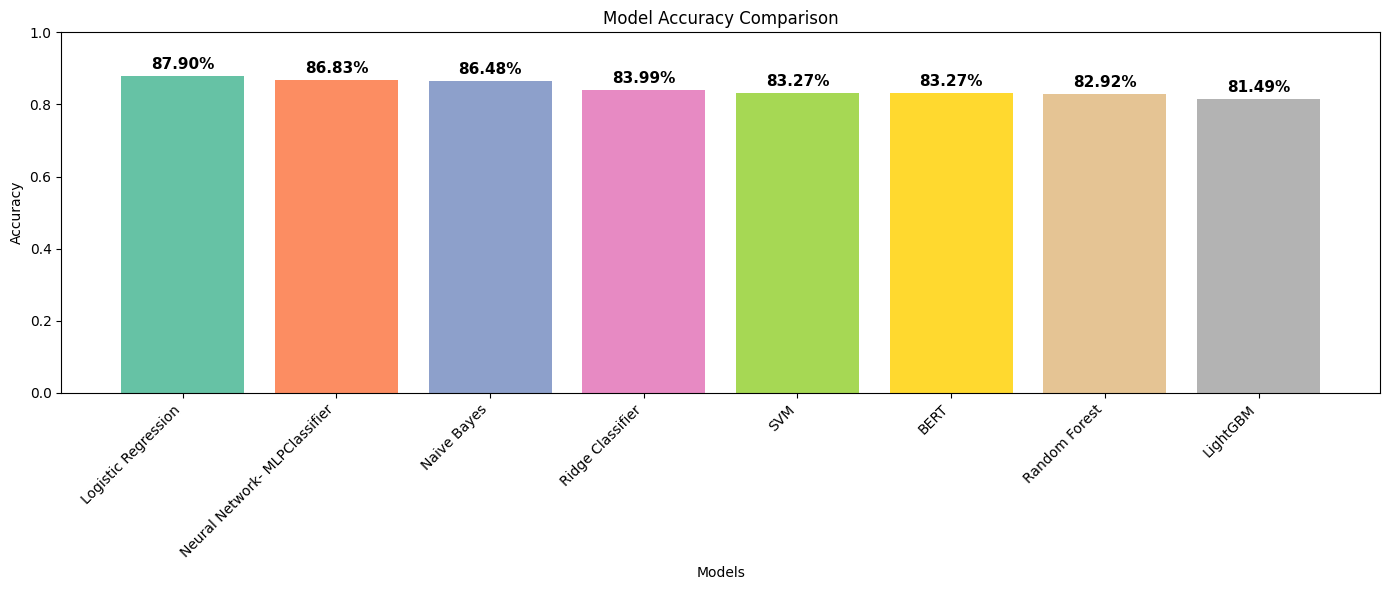

In [ ]:
# Combine and sort model-accuracy pairs
model_acc_pairs = list(zip(model_names, accuracies))
sorted_pairs = sorted(model_acc_pairs, key=lambda x: x[1], reverse=True)
sorted_model_names, sorted_accuracies = zip(*sorted_pairs)

# Plot
plt.figure(figsize=(14, 6))
colors = sns.color_palette('Set2', len(sorted_model_names))
bars = plt.bar(sorted_model_names, sorted_accuracies, color=colors)

# Labels and Title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)

# Annotate bars
for bar, acc in zip(bars, sorted_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{acc:.2%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Saving the best Model

In [ ]:
import joblib

X_text= df['text']
y= df['sentiment_label']

# Vectorize text using TF-IDF
vectorizer= TfidfVectorizer(
    max_features=1000,
    min_df= 2,
    max_df= 0.9,
    stop_words= 'english',
    ngram_range=(1,2))

X= vectorizer.fit_transform(X_text)

# Train LR on best parameters
model= LogisticRegression(penalty= 'l2', C=10, solver= 'liblinear', random_state= 42)
model.fit(X, y)

# Save the vectorizer & model
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(model, 'logistic_model.joblib')

In [ ]:
# Also Saving the clean dataset
df[['sentiment_label', 'text']].to_csv('df.csv')